# 題目:Store Item Demand Forecasting Challenge (商店商品需求預測)

![](https://uploads-ssl.webflow.com/601c16078fdd348ebf868523/603ecb76e4b4c33187aacef1_17%20(1).svg)

# Introduction

資料與挑戰來源 [demand forecasting](https://www.kaggle.com/c/demand-forecasting-kernels-only) Kaggle competition.

Answer some of the questions posed:

* What's the best way to deal with seasonality?
* Should stores be modeled separately, or can you pool them together?
* Does deep learning work better than ARIMA?
* Can either beat xgboost?

* 處理季節性的最佳方法是什麼？
* 商店應該單獨建模，還是可以將它們合併在一起？
* 深度學習是否比 ARIMA 更有效？
* 可以擊敗 xgboost 嗎？

# import Package

In [49]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

from datetime import datetime
plt.style.use('fivethirtyeight')
sns.set()
%matplotlib inline
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import statsmodels.api as sm
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

## for Deep-learing:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adadelta,Adam,RMSprop 
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

import statsmodels.api as sm

# Load DataSet

In [50]:
#load dataset
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])
df = pd.concat([train, test], sort=False) 
df.head()

date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN

In [51]:
print("Train dataset shape:",train.shape)
print("Test dateset shape:",test.shape)

Train dataset shape: (913000, 4)
Test dateset shape: (45000, 4)


# check NA

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      45000 non-null  int64         
 1   date    45000 non-null  datetime64[ns]
 2   store   45000 non-null  int64         
 3   item    45000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.4 MB


In [6]:
train.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [7]:
test.isna().sum()

id       0
date     0
store    0
item     0
dtype: int64

### EDA

To explore the time series data first we need to aggregate the sales by day

In [8]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item','date'], as_index=False)['sales'].sum()

In [9]:
daily_sales

date  sales
0    2013-01-01  13696
1    2013-01-02  13678
2    2013-01-03  14488
3    2013-01-04  15677
4    2013-01-05  16237
...         ...    ...
1821 2017-12-27  20378
1822 2017-12-28  21885
1823 2017-12-29  23535
1824 2017-12-30  24988
1825 2017-12-31  26420

[1826 rows x 2 columns]

### Overall daily sales

In [10]:
# plt.figure(figsize=(25,15))
# plt.xticks(rotation= -80)
# plt.plot(daily_sales['date'],daily_sales['sales'])
# plt.title("原始資料") 
# plt.legend()
# plt.grid()
# plt.show()

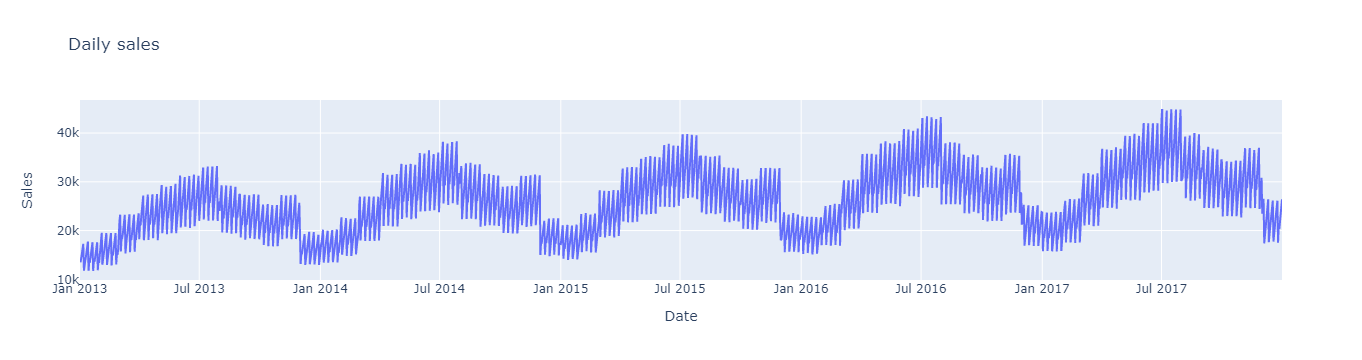

In [11]:
daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

### Daily sales by store

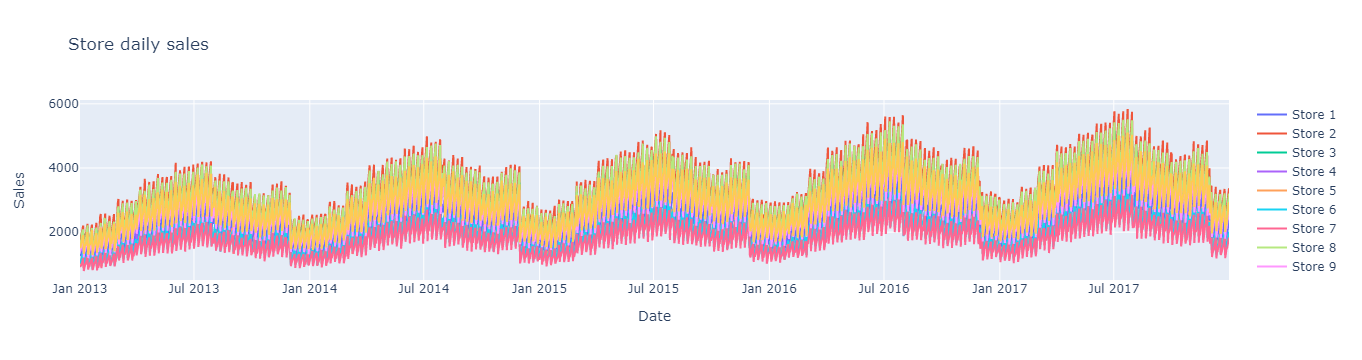

In [12]:
store_daily_sales_sc = []
for store in store_daily_sales['store'].unique():
    current_store_daily_sales = store_daily_sales[(store_daily_sales['store'] == store)]
    store_daily_sales_sc.append(go.Scatter(x=current_store_daily_sales['date'], y=current_store_daily_sales['sales'], name=('Store %s' % store)))

layout = go.Layout(title='Store daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=store_daily_sales_sc, layout=layout)
iplot(fig)

### Daily sales by item

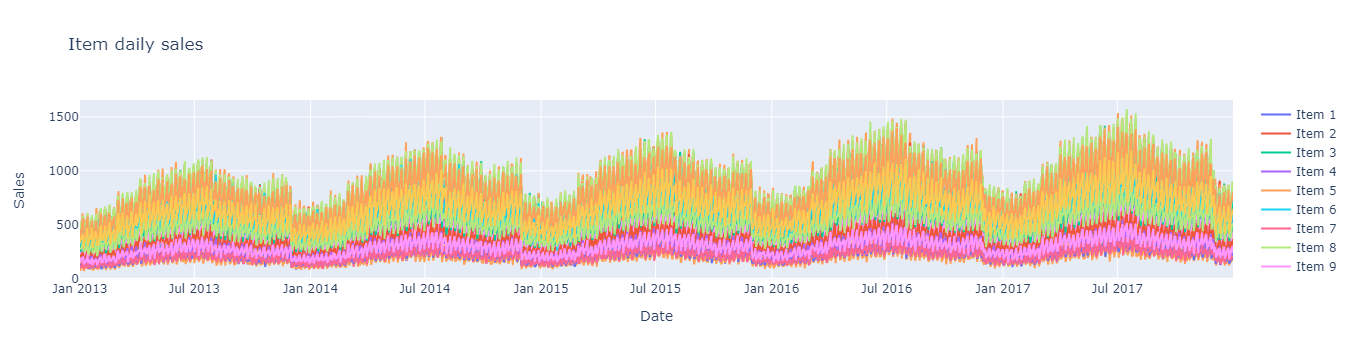

In [13]:
item_daily_sales_sc = []
for item in item_daily_sales['item'].unique():
    current_item_daily_sales = item_daily_sales[(item_daily_sales['item'] == item)]
    item_daily_sales_sc.append(go.Scatter(x=current_item_daily_sales['date'], y=current_item_daily_sales['sales'], name=('Item %s' % item)))

layout = go.Layout(title='Item daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=item_daily_sales_sc, layout=layout)
iplot(fig)

# avg daily sales

In [14]:
store_df = train.copy()
sales_pivoted_df = pd.pivot_table(store_df, index='store', values=['sales','date'], columns='item', aggfunc=np.mean)
sales_pivoted_df['avg_sale'] = sales_pivoted_df.apply(lambda r: r.mean(), axis=1)

In [15]:
def sales_insight(sales_pivoted_df):
    # Let us calculate the average sales of each of the item across all the stores
    sales_across_item_df = sales_pivoted_df.copy()
    # Aggregate the sales per item and add it as a new row in the same dataframe
    sales_across_item_df.loc[11] = sales_across_item_df.apply(lambda r: r.mean(), axis=0)
    # Note the 11th index row, which is the average sale of each of the item across all the stores
    #display(sales_across_item_df.loc[11:])
    avg_sales_per_item_across_stores_df = pd.DataFrame(data=[[i+1,a] for i,a in enumerate(sales_across_item_df.loc[11:].values[0])], columns=['item', 'avg_sale'])
    # And finally, sort by avg sale
    avg_sales_per_item_across_stores_df.sort_values(by='avg_sale', ascending=False, inplace=True)
    # Display the top 10 rows
    display(avg_sales_per_item_across_stores_df.head())
    return (sales_across_item_df,avg_sales_per_item_across_stores_df)

sales_across_item_df,avg_sales_per_item_across_stores_df = sales_insight(sales_pivoted_df)

item   avg_sale
14    15  88.030778
27    28  87.881325
12    13  84.316594
17    18  84.275794
24    25  80.686418

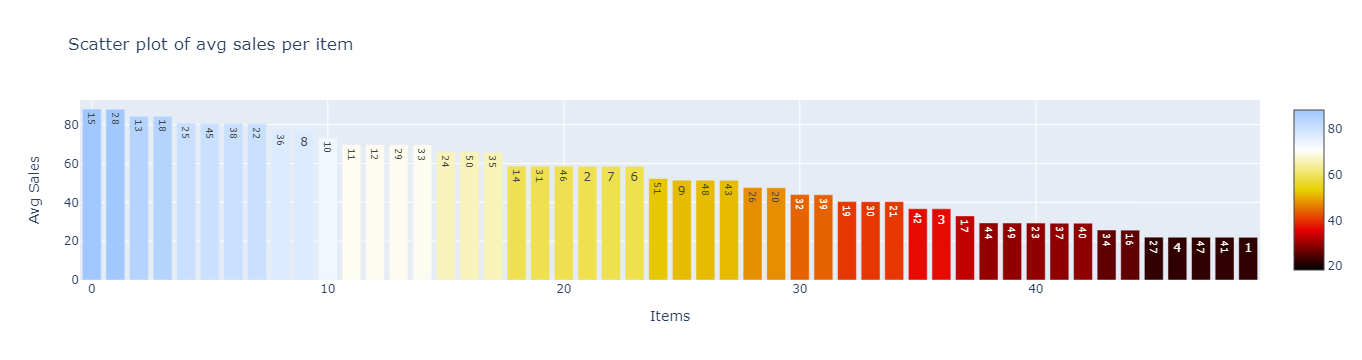

In [16]:
avg_sales_per_item_across_stores_sorted = avg_sales_per_item_across_stores_df.avg_sale.values
# Scatter plot of average sales per item
sales_item_data = go.Bar(
    x=[i for i in range(0, 50)],
    y=avg_sales_per_item_across_stores_sorted,
    marker=dict(
        color=avg_sales_per_item_across_stores_sorted,
        colorscale='Blackbody',
        showscale=True
    ),
    text = avg_sales_per_item_across_stores_df.item.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 55,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
py.iplot(fig,filename='scatter_sales_item')

# Feature Engineering

In [17]:
df

date  store  item  sales       id
0     2013-01-01      1     1   13.0      NaN
1     2013-01-02      1     1   11.0      NaN
2     2013-01-03      1     1   14.0      NaN
3     2013-01-04      1     1   13.0      NaN
4     2013-01-05      1     1   10.0      NaN
...          ...    ...   ...    ...      ...
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0

[958000 rows x 5 columns]

In [18]:
train['date'].dt.month

0          1
1          1
2          1
3          1
4          1
          ..
912995    12
912996    12
912997    12
912998    12
912999    12
Name: date, Length: 913000, dtype: int64

In [19]:
train['date'].dt.dayofweek

0         1
1         2
2         3
3         4
4         5
         ..
912995    2
912996    3
912997    4
912998    5
912999    6
Name: date, Length: 913000, dtype: int64

In [52]:
# 月份
train['month'] = train.date.dt.month
# 銷售是在每月的哪一天進行的
train['day_of_month'] = train.date.dt.day
# 一年中的哪一天進行了銷售
train['day_of_year'] = train.date.dt.dayofyear 
# 在一年中的哪一周進行了銷售
train['week_of_year'] = train.date.dt.weekofyear
# 在一周中的哪一天進行了銷售
train['day_of_week'] = train.date.dt.dayofweek
# 銷售是在哪一年進行的
train['year'] = train.date.dt.year
# 週末與否(The day of the week with Monday=0, Sunday=6)
train["is_wknd"] = train.date.dt.weekday // 5
# 是月初嗎
train['is_month_start'] = train.date.dt.is_month_start.astype(int)
#是月底嗎
train['is_month_end'] = train.date.dt.is_month_end.astype(int) 

In [53]:
# 月份
test['month'] = test.date.dt.month
# 銷售是在每月的哪一天進行的
test['day_of_month'] = test.date.dt.day
# 一年中的哪一天進行了銷售
test['day_of_year'] = test.date.dt.dayofyear 
# 在一年中的哪一周進行了銷售
test['week_of_year'] = test.date.dt.weekofyear
# 在一周中的哪一天進行了銷售
test['day_of_week'] = test.date.dt.dayofweek
# 銷售是在哪一年進行的
test['year'] = test.date.dt.year
# 週末與否(The day of the week with Monday=0, Sunday=6)
test["is_wknd"] = test.date.dt.weekday // 5
# 是月初嗎
test['is_month_start'] = test.date.dt.is_month_start.astype(int)
#是月底嗎
test['is_month_end'] = test.date.dt.is_month_end.astype(int) 

# Split data

In [54]:
train

date  store  item  sales  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end
0      2013-01-01      1     1     13      1             1            1             1            1  2013        0               1             0
1      2013-01-02      1     1     11      1             2            2             1            2  2013        0               0             0
2      2013-01-03      1     1     14      1             3            3             1            3  2013        0               0             0
3      2013-01-04      1     1     13      1             4            4             1            4  2013        0               0             0
4      2013-01-05      1     1     10      1             5            5             1            5  2013        1               0             0
...           ...    ...   ...    ...    ...           ...          ...           ...          ...   ...      ...             ...           ...
912995 2017-12-27     10    50     63     12            27          361            52            2  2017        0               0             0
912996 2017-12-28     10    50     59     12            28          362            52            3  2017        0               0             0
912997 2017-12-29     10    50     74     12            29          363            52            4  2017        0               0             0
912998 2017-12-30     10    50     62     12            30          364            52            5  2017        1               0             0
912999 2017-12-31     10    50     82     12            31          365            52            6  2017        1               0             1

[913000 rows x 13 columns]

In [55]:
cols = [col for col in train.columns if col not in ['date', 'id', "sales"]]
train_x, valid_x, train_y, valid_y = train_test_split(train[cols],train['sales'], test_size=0.2)

In [56]:
valid_y

190894    53
412064    27
694255    23
12268     22
425945    73
          ..
711635    66
420195    62
848655    22
377166    23
482925    21
Name: sales, Length: 182600, dtype: int64

In [57]:
train_x.shape, valid_x.shape, train_y.shape, valid_y.shape

((730400, 11), (182600, 11), (730400,), (182600,))

## 9. XGBOOST

XGBoost (eXtreme Gradient Boosting) is a direct application of Gradient Boosting for decision trees

Main advantages are as follows:
1. Easy to use
2. Computational efficiency
3. Model Accuracy
4. Feasibility — easy to tune parameters and modify objectives.

In [191]:
model_xgb=XGBRegressor()

In [192]:
model_xgb.fit(train_x,train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=20,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [193]:
y_pred=model_xgb.predict(valid_x)

In [194]:
print('R2 score using XG Boost= ',r2_score(valid_y, y_pred), '/ 1.0')
print('MSE score using XG Boost= ',mean_squared_error(valid_y, y_pred), '/ 0.0')

R2 score using XG Boost=  0.9273607470722182 / 1.0
MSE score using XG Boost=  60.14972902606929 / 0.0


## After tune

In [195]:
model_xgb=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                   colsample_bynode=1, colsample_bytree=1, gamma=5.68,
                  importance_type='gain',learning_rate=0.172, max_delta_step=0, max_depth=9,
                  min_child_weight=0.4261,n_estimators=100,num_parallel_tree=1, random_state=123,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1,subsample=0.82, tree_method='exact',validate_parameters=1)

In [196]:
model_xgb.fit(train_x,train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=5.68, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.172, max_delta_step=0,
             max_depth=9, min_child_weight=0.4261, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=20,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.82,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [197]:
y_pred=model_xgb.predict(valid_x)

In [198]:
print('R2 score using XG Boost= ',r2_score(valid_y, y_pred), '/ 1.0')
print('MSE score using XG Boost= ',mean_squared_error(valid_y, y_pred), '/ 0.0')

R2 score using XG Boost=  0.9318048743777674 / 1.0
MSE score using XG Boost=  56.4697207328686 / 0.0


# test - predict

In [129]:
test[cols]

store  item  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end
0          1     1      1             1            1             1            0  2018        0               1             0
1          1     1      1             2            2             1            1  2018        0               0             0
2          1     1      1             3            3             1            2  2018        0               0             0
3          1     1      1             4            4             1            3  2018        0               0             0
4          1     1      1             5            5             1            4  2018        0               0             0
...      ...   ...    ...           ...          ...           ...          ...   ...      ...             ...           ...
44995     10    50      3            27           86            13            1  2018        0               0             0
44996     10    50      3            28           87            13            2  2018        0               0             0
44997     10    50      3            29           88            13            3  2018        0               0             0
44998     10    50      3            30           89            13            4  2018        0               0             0
44999     10    50      3            31           90            13            5  2018        1               0             1

[45000 rows x 11 columns]

In [131]:
y_pred=model.predict(test[cols])

In [136]:
submission = pd.DataFrame({"id":test["id"],
                        "sales":y_pred
                        })

In [137]:
submission.head()

id      sales
0   0  12.338324
1   1  15.794227
2   2  14.098604
3   3  15.956207
4   4  18.405092

In [140]:
#submission.to_csv('submission.csv',index = False)

In [128]:
train[cols],test['sales']

id       date  store  item  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end
0          0 2018-01-01      1     1      1             1            1             1            0  2018        0               1             0
1          1 2018-01-02      1     1      1             2            2             1            1  2018        0               0             0
2          2 2018-01-03      1     1      1             3            3             1            2  2018        0               0             0
3          3 2018-01-04      1     1      1             4            4             1            3  2018        0               0             0
4          4 2018-01-05      1     1      1             5            5             1            4  2018        0               0             0
...      ...        ...    ...   ...    ...           ...          ...           ...          ...   ...      ...             ...           ...
44995  44995 2018-03-27     10    50      3            27           86            13            1  2018        0               0             0
44996  44996 2018-03-28     10    50      3            28           87            13            2  2018        0               0             0
44997  44997 2018-03-29     10    50      3            29           88            13            3  2018        0               0             0
44998  44998 2018-03-30     10    50      3            30           89            13            4  2018        0               0             0
44999  44999 2018-03-31     10    50      3            31           90            13            5  2018        1               0             1

[45000 rows x 13 columns]

# LGBM

In [199]:
model_lgb = lgb.LGBMRegressor()

In [200]:
model_lgb.fit(train_x, train_y)

LGBMRegressor()

In [201]:
y_pred=model_lgb.predict(valid_x)

In [202]:
print('R2 score using LGBM= ',r2_score(valid_y, y_pred), '/ 1.0')
print('MSE score using LGBM= ',mean_squared_error(valid_y, y_pred), '/ 0.0')

R2 score using LGBM=  0.9171067973010607 / 1.0
MSE score using LGBM=  68.64062444862054 / 0.0


# After tune

In [38]:
# model = lgb.LGBMRegressor(
#     boosting_type='gbdt', num_leaves=50, max_depth=15,   
#                     min_split_gain = 0.1,
#                     learning_rate=0.02, 
#                     min_child_weight=3,
#                     subsample=0.5,  
#                     colsample_bytree=0.5, 
#                     n_estimators=150,
#                     n_jobs = 4,
#                     reg_alpha=0.05,
#                     importance_type='split')

In [203]:
model_lgb = lgb.LGBMRegressor(
    boosting_type='gbdt', num_leaves=64, max_depth=15, nthread =10,task = 'train',
    objective = 'regression_l1',metric = 'mape',feature_fraction = 0.9,bagging_fraction=0.8,
    bagging_freq = 5,learning_rate=0.2, n_estimators=150,min_child_weight= 6.996,
    min_split_gain= 0.037)

In [204]:
model_lgb.fit(train_x, train_y)

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=10 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.9,
              learning_rate=0.2, max_depth=15, metric='mape',
              min_child_weight=6.996, min_split_gain=0.037, n_estimators=150,
              nthread=10, num_leaves=64, objective='regression_l1',
              task='train')

In [205]:
y_pred=model_lgb.predict(valid_x)

In [206]:
print('R2 score using LGBM= ',r2_score(valid_y, y_pred), '/ 1.0')
print('MSE score using LGBM= ',mean_squared_error(valid_y, y_pred), '/ 0.0')

R2 score using LGBM=  0.9310677765732653 / 1.0
MSE score using LGBM=  57.080082643536734 / 0.0


# test - predict

In [146]:
test[cols]

store  item  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end
0          1     1      1             1            1             1            0  2018        0               1             0
1          1     1      1             2            2             1            1  2018        0               0             0
2          1     1      1             3            3             1            2  2018        0               0             0
3          1     1      1             4            4             1            3  2018        0               0             0
4          1     1      1             5            5             1            4  2018        0               0             0
...      ...   ...    ...           ...          ...           ...          ...   ...      ...             ...           ...
44995     10    50      3            27           86            13            1  2018        0               0             0
44996     10    50      3            28           87            13            2  2018        0               0             0
44997     10    50      3            29           88            13            3  2018        0               0             0
44998     10    50      3            30           89            13            4  2018        0               0             0
44999     10    50      3            31           90            13            5  2018        1               0             1

[45000 rows x 11 columns]

In [147]:
y_pred=model.predict(test[cols])

In [148]:
submission = pd.DataFrame({"id":test["id"],
                        "sales":y_pred
                        })

In [149]:
submission.head()

id      sales
0   0  11.190229
1   1  13.419064
2   2  13.419064
3   3  13.488010
4   4  14.882063

In [150]:
#submission.to_csv('submission.csv',index = False)

# ARIMA

ARIMA is one of the most classic time series forecasting models. During the modeling process, we mainly want to find 3 parameters. Auto-regression(AR) term, namly the lags of previous value; Integral(I) term for non-stationary differencing and Moving Average(MA) for error term.  

I'm a newbie in this field. Found many online tutorials used grid search technique(auto.arima in R). Meanwhile I also found many hypothesis test to validate the time series, i.e. see if it's stationary, looking at ACF and PACF to suggest a AR term etc... 

Facebook has a package called prophet, which is quite complex and consider many things automaticlly. But out of curiosity, I want to understand what's the reasoning behind the model. ARIMA is definitely a good starting point.


參考連結:
- https://adaptable-haze-butterfly-551.medium.com/arima時間序列模型python應用-銅價格預測-一-4f91693e3ec6
- https://www.kaggle.com/code/poiupoiu/how-to-use-sarimax
- https://www.kaggle.com/code/sumi25/understand-arima-and-tune-p-d-q

In [44]:
# train_arima = pd.read_csv('train.csv' ,parse_dates=['date'],index_col='date')#('../input/train.csv' ,parse_dates=['date'],index_col='date')
# test_arima = pd.read_csv('test.csv', parse_dates=['date'],index_col='date')#('../input/test.csv', parse_dates=['date'],index_col='date')
# #train_test_split
# tr_start,tr_end = '2014-01-01','2017-09-30'
# te_start,te_end = '2017-10-01','2017-12-31'
# tra = train_arima['sales'][tr_start:tr_end].dropna()
# tes = train_arima['sales'][te_start:te_end].dropna()

In [45]:
# arima_mod6 = sm.tsa.ARIMA(tra, order=(6,1,0)).fit()
# print(arima_mod6.summary())

# Lstm

In [113]:
train_x

store  item  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end
502753      6    28      8            27          239            35            2  2014        0               0             0
643790      3    36     11             5          309            45            3  2015        0               0             0
214793      8    12      2            26           57             8            4  2016        0               0             0
100638      6     6      7            28          209            30            6  2013        1               0             0
859563      1    48      9             5          249            36            0  2016        0               0             0
...       ...   ...    ...           ...          ...           ...          ...   ...      ...             ...           ...
834674      8    46      7            12          193            28            4  2013        0               0             0
532944      2    30      4            28          118            17            4  2017        0               0             0
434245      8    24      1            23           23             4            0  2017        0               0             0
614146      7    34      9             3          246            36            2  2014        0               0             0
188876      4    11      3            10           69            11            1  2015        0               0             0

[730400 rows x 11 columns]

In [98]:
X_train_series = train_x.values.reshape((train_x.shape[0], train_x.shape[1], 1))
X_valid_series = valid_x.values.reshape((valid_x.shape[0], valid_x.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (730400, 11, 1)
Validation set shape (182600, 11, 1)


In [101]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='tanh', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 50)                10400     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [102]:
lstm_history = model_lstm.fit(X_train_series, train_y, validation_data=(X_valid_series, valid_y), epochs=5,batch_size = 128)

Epoch 1/5
5707/5707 [==============================] - 22s 4ms/step - loss: 790.7250 - val_loss: 521.2855
Epoch 2/5
5707/5707 [==============================] - 25s 4ms/step - loss: 507.1279 - val_loss: 492.0464
Epoch 3/5
5707/5707 [==============================] - 29s 5ms/step - loss: 492.7778 - val_loss: 482.6503
Epoch 4/5
5707/5707 [==============================] - 27s 5ms/step - loss: 478.6162 - val_loss: 468.6211
Epoch 5/5
5707/5707 [==============================] - 25s 4ms/step - loss: 461.8060 - val_loss: 459.5065


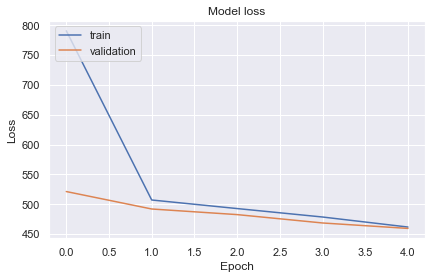

In [103]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predict = model_lstm.predict(X_test_series)

1407/1407 [==============================] - 2s 2ms/step


In [122]:
print('R2 score using XG Boost= ',r2_score(valid_y, predict), '/ 1.0')
print('MSE score using XG Boost= ',mean_squared_error(valid_y, predict), '/ 0.0')

R2 score using XG Boost=  0.4450815583736891 / 1.0
MSE score using XG Boost=  459.5062937744684 / 0.0


# test predict

In [163]:
X_test_series = test[cols].values.reshape((test[cols].shape[0], test[cols].shape[1], 1))

In [169]:
type(test["id"])

pandas.core.series.Series

In [171]:
predict.shape

(45000, 1)

In [184]:
submission_sub = pd.DataFrame(predict,columns=["sales"])

In [185]:
submission_sub

sales
0       7.865890
1      10.431241
2      10.025048
3      10.639150
4      12.632113
...          ...
44995  45.638687
44996  47.360683
44997  49.197567
44998  51.258034
44999  55.739822

[45000 rows x 1 columns]

In [188]:
submission = pd.DataFrame({"id":test["id"],
                        "sales":submission_sub["sales"]
                        })

In [190]:
# submission.to_csv('submission.csv',index = False)

# to be continued

# compare

#### XGB on train and validation

In [211]:
xgb_train_pred = model_xgb.predict(train_x)
xgb_valid_pred = model_xgb.predict(valid_x)

print("---Train---")
print('MSE score on train using XGBoost= ',mean_squared_error(train_y, xgb_train_pred))
print('RMSE score on train using XGBoost= ', np.sqrt(mean_squared_error(train_y, xgb_train_pred)))
print('R2 score on train using XGBoost= ',r2_score(train_y, xgb_train_pred))

print("---Validation---")
print('MSE score on Validation using XGBoost= ',mean_squared_error(valid_y, xgb_valid_pred))
print('RMSE score on Validation using XGBoost= ', np.sqrt(mean_squared_error(valid_y, xgb_valid_pred)))
print('R2 score on Validation using XGBoost= ',r2_score(valid_y, xgb_valid_pred))

---Train---
MSE score on train using XGBoost=  52.62245740998404
RMSE score on train using XGBoost=  7.2541338152796735
R2 score on train using XGBoost=  0.9365891465712765
---Validation---
MSE score on Validation using XGBoost=  56.4697207328686
RMSE score on Validation using XGBoost=  7.514633772371652
R2 score on Validation using XGBoost=  0.9318048743777674


#### LGB on train and validation

In [213]:
lgb_train_pred = model_lgb.predict(train_x)
lgb_valid_pred = model_lgb.predict(valid_x)

print("---Train---")
print('MSE score on train using LGBM= ',mean_squared_error(train_y, lgb_train_pred))
print('RMSE score on train using LGBM= ', np.sqrt(mean_squared_error(train_y, lgb_train_pred)))
print('R2 score on train using LGBM= ',r2_score(train_y, lgb_train_pred))

print("---Validation---")
print('MSE score on Validation using LGBM= ',mean_squared_error(valid_y, lgb_valid_pred))
print('RMSE score on Validation using LGBM= ', np.sqrt(mean_squared_error(valid_y, lgb_valid_pred)))
print('R2 score on Validation using LGBM= ',r2_score(valid_y, lgb_valid_pred))

---Train---
MSE score on train using LGBM=  56.24673835333006
RMSE score on train using LGBM=  7.499782553736479
R2 score on train using LGBM=  0.9322218334697141
---Validation---
MSE score on Validation using LGBM=  57.080082643536734
RMSE score on Validation using LGBM=  7.555136176372781
R2 score on Validation using LGBM=  0.9310677765732653


#### LSTM on train and validation

In [215]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_lstm.predict(X_valid_series)

print("---Train---")
print('MSE score on train using LGBM= ',mean_squared_error(train_y, lstm_train_pred))
print('RMSE score on train using LGBM= ', np.sqrt(mean_squared_error(train_y, lstm_train_pred)))
print('R2 score on train using LGBM= ',r2_score(train_y, lstm_train_pred))

print("---Validation---")
print('MSE score on Validation using LGBM= ',mean_squared_error(valid_y, lstm_valid_pred))
print('RMSE score on Validation using LGBM= ', np.sqrt(mean_squared_error(valid_y, lstm_valid_pred)))
print('R2 score on Validation using LGBM= ',r2_score(valid_y, lstm_valid_pred))

5707/5707 [==============================] - 7s 1ms/step
---Train---
MSE score on train using LGBM=  458.0464123832667
RMSE score on train using LGBM=  21.402018885686154
R2 score on train using LGBM=  0.44804717702755426
---Validation---
MSE score on Validation using LGBM=  459.5062937744684
RMSE score on Validation using LGBM=  21.436097913903744
R2 score on Validation using LGBM=  0.4450815583736891


# Conclusion

- 以比較與訓練時間考量Xgboost可以達到不錯的成效
- 可再將資料繼續整理(目前只有切開時間)可以在探索看看哪些是可以再新增準確率的資料
- 可以試著將submission存出來上傳至Kaggle